In [ ]:
# languages: English, Hindi, Arabic
# looking for: Mandarin, Japanese, Korean

# importing
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, MaxPooling2D, Conv2D, Flatten
import tensorflow.keras.backend as K
from keras import regularizers

In [ ]:
# uploading english data
df = pd.read_csv("A_Z Handwritten Data.csv").astype('float32')
df.rename(columns = {'0':'label'}, inplace=True)

# drop character labels
engX = df.drop('label', axis = 1)
print(engX.shape)

(372450, 784)


In [ ]:
# uploading arabic data
df = pd.read_csv("Arabic.csv").astype('float32')

# resize and reshape araX
import cv2
araX = []
for i in range(13439):
  img = cv2.resize(df.iloc[i].values.reshape(32, 32), (28, 28))
  araX.append(img)
araX = np.array(araX)
araX = araX.reshape(13439, 784)
print(araX.shape)

(13439, 784)


In [ ]:
# upload devanagari.zip
from google.colab import files
uploaded = files.upload()

Saving Devanagari.zip to Devanagari.zip


In [ ]:
# extract all from devanagari.zip
import zipfile
import io

import zipfile
with zipfile.ZipFile('Devanagari.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# creates file path to devanagari images
import cv2
import glob

file_paths = glob.glob('/content/Devanagari/Devanagari/*')
X = []
y = []
# print(file_paths)

In [ ]:
for i in file_paths:
  img = cv2.imread(i, 0) # grayscales images
  try:
    img = cv2.resize(img, (28, 28)) # resize to 28x28
    X.append(img)
    y.append(0)
  except:
    pass

# creates devanagari matrix and y
devX = np.array(X)
devy = np.array(y)

print(devX.shape)
print(devy.shape)

(4852, 28, 28)
(4852,)


In [ ]:
# reshape devX to same as engX
devX = devX.reshape(4852, 28 * 28)

print(devX[0,:])

devX_new = np.zeros((4852,28*28))
for i in range(0,4852):
  devX_new[i,:] = 255 - devX[i,:] 
print(devX.shape)
print(devy.shape)

In [ ]:
# create array of 1s for arabic images
aray = np.zeros([13439, 1])
print(aray.shape)
print(araX.shape)

# add array to araX
ara = np.hstack((araX, aray))
print(ara.shape)

# create array of 1s for english images
engy = np.ones([372450, 1])
print(engy.shape)
print(engX.shape)

# add engy to engX
eng = np.hstack((engX, engy))
print(eng.shape)

# create array of 2s for dev images
devy = np.ones((4852, 1))*2
print(devy.shape)

# add devy to devX
dev = np.hstack((devX_new, devy))
print(dev.shape)

(13439, 1)
(13439, 784)
(13439, 785)
(372450, 1)
(372450, 784)
(372450, 785)
(4852, 1)
(4852, 785)


In [ ]:
# combine ara and eng
combined = np.vstack((ara, eng))
print(combined.shape)

# combine ara/eng and dev
combined = np.vstack((combined, dev))
print(combined.shape)

(385889, 785)
(390741, 785)


In [ ]:
# split X into train and test data
from sklearn.model_selection import train_test_split

combX = combined[:, 0:-1]
print(combX.shape)

comby = combined[:, -1]
print(comby.shape)

X_train, X_test, y_train, y_test = train_test_split(combX, comby, test_size = 0.33)
print(X_train.shape)
print(X_test.shape)

X_train = X_train[0:20000, :]
y_train = y_train[0:20000]
X_test = X_test[0:10000, :]
y_test = y_test[0:10000]

(390741, 784)
(390741,)
(261796, 784)
(128945, 784)


In [ ]:
#reshape into 28,28 for your Convolution layers
X_train_new = X_train.reshape(20000, 28, 28, 1)
X_test_new = X_test.reshape(10000, 28, 28, 1)

In [ ]:
# normalizing data

X_train_scale = X_train_new / 255
X_test_scale = X_test_new / 255

In [ ]:
K.clear_session()

# create model and add layers
act = 'relu'
model = Sequential([
    Conv2D(64, (3, 3), activation = act, input_shape = (28, 28, 1), name = 'conv1'),
    MaxPooling2D(2, 2, name = 'maxpool1'),
    Conv2D(128, (3, 3), activation = act, name = 'conv3'),
    MaxPooling2D(2, 2, name = 'maxpool2'),
    Flatten(name = 'flatten'),
    Dense(64, activation = act, name = 'dense1', 
          kernel_regularizer = regularizers.l2(0.003)),
    Dense(3, activation = 'softmax', name = 'output', 
          kernel_regularizer = regularizers.l2(0.003))
])

W0719 14:12:20.279370 140207016834944 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(lr = 0.0001)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 64)        640       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 13, 13, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 11, 11, 128)       73856     
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                204864    
_________________________________________________________________
output (Dense)               (None, 3)                 1

In [ ]:
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
hist = model.fit(x = X_train_scale, y = y_train, batch_size = 50, epochs = 10, validation_split = 0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 6s 356us/sample - loss: 0.4182 - acc: 0.9586 - val_loss: 0.2269 - val_acc: 0.9827
Epoch 2/10
16000/16000 [==============================] - 2s 97us/sample - loss: 0.1695 - acc: 0.9850 - val_loss: 0.1450 - val_acc: 0.9868
Epoch 3/10
16000/16000 [==============================] - 2s 98us/sample - loss: 0.1131 - acc: 0.9890 - val_loss: 0.1061 - val_acc: 0.9898
Epoch 4/10
16000/16000 [==============================] - 2s 97us/sample - loss: 0.0856 - acc: 0.9897 - val_loss: 0.0894 - val_acc: 0.9887
Epoch 5/10
16000/16000 [==============================] - 2s 100us/sample - loss: 0.0705 - acc: 0.9914 - val_loss: 0.0739 - val_acc: 0.9905
Epoch 6/10
16000/16000 [==============================] - 2s 99us/sample - loss: 0.0597 - acc: 0.9927 - val_loss: 0.0672 - val_acc: 0.9905
Epoch 7/10
16000/16000 [==============================] - 2s 98us/sample - loss: 0.0528 - acc: 0.9934 - val_loss: 0

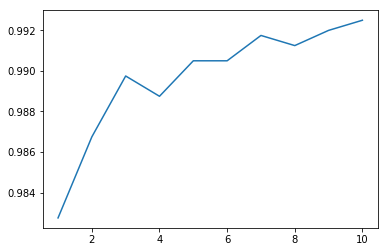

In [ ]:
vacc = hist.history['val_acc']
plt.plot(np.arange(1, 11), vacc)

This language is: Devanagari


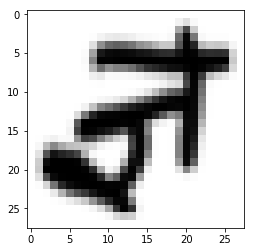

In [ ]:
# testing on new input
import skimage
xts = skimage.io.imread('102580.png')
xts = cv2.resize(xts, (28, 28))
xts = 255 - xts[:, :]
plt.imshow(xts, cmap = "gray")

xts = xts / 255
xts = xts.reshape(1, 28, 28, 1)
yhat = model.predict_classes(xts)

if yhat == 0:
  print('This language is: English')
elif yhat == 1:
  print('This language is: Arabic')
elif yhat == 2:
  print('This language is: Devanagari')

# Extra

In [ ]:
# # upload devanagari.zip
# from google.colab import files
# uploaded = files.upload()

Saving Devanagari (1).zip to Devanagari (1).zip


In [ ]:
# # extract all from devanagari.zip
# import zipfile
# import io

# import zipfile
# with zipfile.ZipFile('Devanagari (1).zip', 'r') as zip_ref:
#     zip_ref.extractall()

In [ ]:
# # creates file path to russian images
# import cv2
# import glob

# file_paths = glob.glob('/content/Devanagari/Devanagari/*')
# X = []
# y = []
# print(file_paths)

['/content/Devanagari/Devanagari/27230.jpg', '/content/Devanagari/Devanagari/15524.jpg', '/content/Devanagari/Devanagari/10770.jpg', '/content/Devanagari/Devanagari/22461.jpg', '/content/Devanagari/Devanagari/32155.jpg', '/content/Devanagari/Devanagari/2655.jpg', '/content/Devanagari/Devanagari/24397.jpg', '/content/Devanagari/Devanagari/24840.jpg', '/content/Devanagari/Devanagari/28191.jpg', '/content/Devanagari/Devanagari/20147.jpg', '/content/Devanagari/Devanagari/36262.jpg', '/content/Devanagari/Devanagari/20054.jpg', '/content/Devanagari/Devanagari/36407.jpg', '/content/Devanagari/Devanagari/1781.jpg', '/content/Devanagari/Devanagari/31061.jpg', '/content/Devanagari/Devanagari/37268.jpg', '/content/Devanagari/Devanagari/20158.jpg', '/content/Devanagari/Devanagari/37898.jpg', '/content/Devanagari/Devanagari/44513.jpg', '/content/Devanagari/Devanagari/24876.jpg', '/content/Devanagari/Devanagari/37891.jpg', '/content/Devanagari/Devanagari/25539.jpg', '/content/Devanagari/Devanagari/2

In [ ]:
# for i in file_paths:
#   img = cv2.imread(i, 0) # grayscales images
#   try:
#     img = cv2.resize(img, (28, 28)) # resize to 28x28
#     X.append(img)
#     y.append(0)
#   except:
#     pass

# # creates russian matrix and y
# devX = np.array(X)
# devy = np.array(y)

# print(devX.shape)
# print(devy.shape)

(4852, 28, 28)
(4852,)


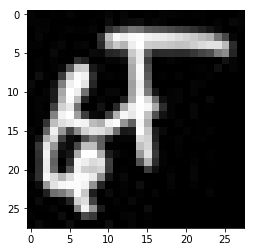

In [ ]:
# plt.imshow(devX[0, :, :], cmap ='gray')

In [ ]:
# # reshape rusX to same as engX
# devX = devX.reshape(4852, 28 * 28)

# print(devX[0,:])

# devX_new = np.zeros((4852,28*28))
# for i in range(0,4852):
#   devX_new[i,:] = 255 - devX[i,:] 
# print(devX.shape)
# print(devy.shape)


[  4   0   0   2   1   5   1   0   0   2   6   0   6   0   0   2   0   4
   4   2   1   2   2   0   0   0   0   3   3   3   3   0   0   0   0   0
   2   0  12   0   8  11  13   3   7   4   0   0   0   0   1   0   4   0
   8   5   0   4   4   0   1   4   2   2   6   0  47  68  94 118 112  89
  84  81  73  64  58  49  35  22   8   0   0   3   0   6   0   0   2   0
   0   0   0  52 191 249 237 249 252 239 234 233 227 218 209 200 187 176
 117  71   6   0   3   3   0   3   7   0   4   6   0  40 162 201 181 238
 255 205 201 202 198 193 195 206 218 225 225 186  45   0   0   0   0   9
   1   0   1   0  10   8  36  41  56 201 235  95  39  43  44  42  43  54
  68  77 124 140  37   0   0   3   0   3   0   1  49  33   0   0   5   5
  13 180 236  62   0   2   5   2   0   0   0   0   0  18   5   0   0   3
   0   3   9  86 200 206  24   8   0   0   3 169 249  79   0   0   0   0
   0   2   3   1  15   0   5   1   0  14   2   0  59 199 250 240  49   2
   4   2   4 167 247  89   0   2   0   4   0   0   

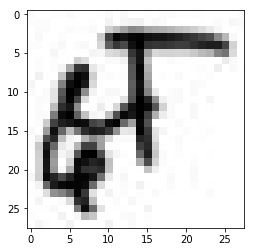

In [ ]:
# # checking colors
# devX_new_checking = devX_new.reshape(4852, 28, 28)
# plt.imshow(devX_new_checking[0, :, :], cmap = "gray")

In [ ]:
# # add rusy to rusX
# devy = np.ones((4852, 1))*2
# print(devy.shape)

# dev = np.hstack((devX_new, devy))
# print(dev.shape)

(4852, 1)
(4852, 785)


In [ ]:
# # upload russian.zip file
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# # extract all from russian.zip
# import zipfile
# import io

# import zipfile
# with zipfile.ZipFile('Russian.zip', 'r') as zip_ref:
#     zip_ref.extractall()

In [ ]:
# # creates file path to russian images
# import cv2
# import glob

# file_paths = glob.glob('/content/BulkResizePhotos/*')
# X = []
# y = []
# print(file_paths)

In [ ]:
# for i in file_paths:
#   img = cv2.imread(i, 0) # grayscales images
#   try:
#     img = cv2.resize(img, (28, 28)) # resize to 28x28
#     X.append(img)
#     y.append(0)
#   except:
#     pass

# # creates russian matrix and y
# rusX = np.array(X)
# rusy = np.array(y)

In [ ]:
# # reshape rusX to same as engX
# rusX = rusX.reshape(1568, 28 * 28)
# print(rusX.shape)
# print(rusy.shape)

In [ ]:
# # add rusy to rusX
# rusy = rusy.reshape(1568,1)
# rus = np.hstack((rusX,rusy))
# print(rus.shape)

In [ ]:
# plt.figure(figsize = (12, 10))
# row, columns = 4, 4
# for i in range(16):
#   img = cv2.resize(araX.iloc[i].values.reshape(32, 32),(28,28))
#   plt.subplot(columns, row, i + 1)
#   plt.imshow(img, cmap = 'Greys')
# plt.show()